train_dataset.shape 40
test_dataset.shape 10
Epoch [1/10], Train Loss: 0.4238, Test Loss: 0.2434
Epoch [2/10], Train Loss: 0.1192, Test Loss: 0.0380
Epoch [3/10], Train Loss: 0.0186, Test Loss: 0.0082
Epoch [4/10], Train Loss: 0.0053, Test Loss: 0.0028
Epoch [5/10], Train Loss: 0.0020, Test Loss: 0.0014
Epoch [6/10], Train Loss: 0.0011, Test Loss: 0.0009
Epoch [7/10], Train Loss: 0.0008, Test Loss: 0.0008
Epoch [8/10], Train Loss: 0.0007, Test Loss: 0.0007
Epoch [9/10], Train Loss: 0.0005, Test Loss: 0.0003
Epoch [10/10], Train Loss: 0.0005, Test Loss: 0.0005


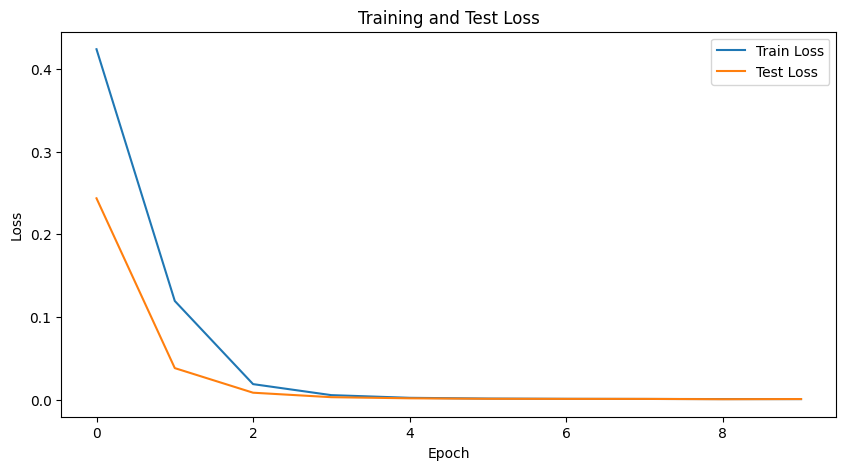

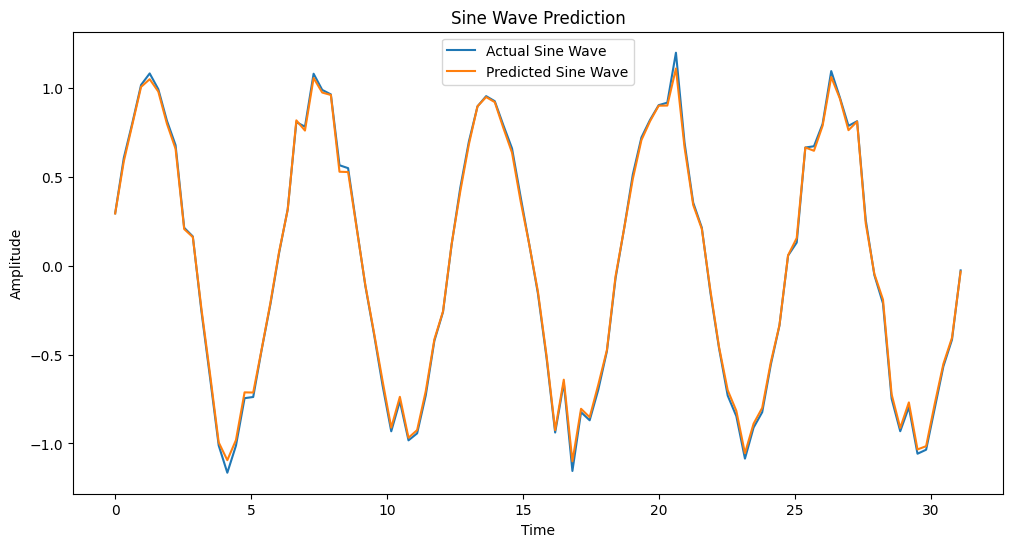

In [1]:
#!/usr/bin/env python3

import pdb
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from ssm_nn.model import Model


# Hyperparameters
d_model = 32
d_state = 4
expansion_factor = 2
num_layers = 2
input_size = 1
output_size = 1
conv_kernel = 3
seq_len = 100
batch_size = 1
learning_rate = 0.001
num_epochs = 10
torch.manual_seed(42)

# Dataset Class
class SineWaveDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Generate Sine Wave Data
def generate_sine_wave(seq_len, num_samples):
    x = np.linspace(0, 10 * np.pi, seq_len)
    y = np.sin(x)
    y = np.tile(y,(num_samples,1))
    y = y + np.random.normal(0, 0.1, size=(num_samples,seq_len))
    return torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Create the Dataset
dataset = generate_sine_wave(seq_len, batch_size*50)
train_size = int(len(dataset) * 0.8)

train_dataset = SineWaveDataset(dataset[:train_size])
test_dataset = SineWaveDataset(dataset[train_size:])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('train_dataset.shape',len(train_dataset))
print('test_dataset.shape',len(test_dataset))

# Model, Loss, Optimizer
model = Model(d_model, d_state, expansion_factor, num_layers, input_size, output_size, conv_kernel)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training Loop
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_sequence = batch[:, :-1]
        target_sequence = batch[:, 1:]
        predicted_sequence = model(input_sequence)
        loss = criterion(predicted_sequence, target_sequence)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_sequence = batch[:, :-1]
            target_sequence = batch[:, 1:]
            predicted_sequence = model(input_sequence)
            loss = criterion(predicted_sequence, target_sequence)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Plotting Training and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Prediction Visualization
model.eval()
with torch.no_grad():
  batch = next(iter(test_loader))
  optimizer.zero_grad()
  input_sequence = batch[:, :-1]
  target_sequence = batch[:, 1:]
  predicted_output = model(input_sequence)
  predicted_output_array = predicted_output.squeeze().detach()
  actual_output_array = target_sequence.squeeze().detach()

  time = np.linspace(0, 10 * np.pi, seq_len)
  plt.figure(figsize=(12, 6))
  plt.plot(time[:-1], actual_output_array, label='Actual Sine Wave')
  plt.plot(time[:-1], predicted_output_array, label='Predicted Sine Wave')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.title('Sine Wave Prediction')
  plt.legend()
  plt.show()
